# NASA Exoplanet Science Institute 

***Project Title***: Exoplanet identification using Deep Learning

***Project Data Scientist***: Christopher A. Rodriguez Principe

***Scope of Project***: The goal of this project is to create a Neural Network able to identify exoplanets in the Kepler Object of Interest Dataset.

# Import Libraries & Data

For starters we need to import all the libraries that will be used in the implemention of our project.

In [1]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from dataclasses import replace

from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    Our dataset was gathered from Kaggle and downloaded as a CSV file.

    The Dataset has a total of 9,564 rows and 50 variables (columns) it has an aproximate size of 3.7 MB.

In [2]:
# Importing Kepler Obkect of Interest Data
DF =pd.read_csv(r'/Users/christopher/Desktop/TFM/cumulative.csv')

#Display size of DF
DF.shape

(9564, 50)

# Data Engineering #

## Data Cleaning ##

    We now need to take the necessary procedures to clean our data to implement our model. 

    The following columns in the 'dropped' variable below contains columns that serve as identification of the Kepler Object of Interest(KOI) or columns with unique values. 
    These need to be eliminated from our dataset since they do not add any value to our model.

In [3]:
#Create List with identification Columns & Unique_Value Columns
dropped = ['rowid','kepid','kepoi_name','kepler_name','koi_teq_err1','koi_teq_err2','koi_tce_delivname']

#Dropping KOI dentification Columns & Unique_Value Columns
DF = DF.drop(dropped,1)

/var/folders/cm/2vncb7d5433gcddk1v7h2mph0000gn/T/ipykernel_1687/3111228662.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  DF = DF.drop(dropped,1)


    Next step into data cleaning, we need to count the amount of NaN in koi_score variable and we filter our dataset to eliminate NaN values from our dataset as well.  

In [4]:
#Count of NaN values in 'koi_score'
DF.koi_score.isna().sum()

#Filter out NaN values in 'koi_score'
DF = DF[DF['koi_score'].notnull()]
DF.reset_index(drop=True,inplace=True) #Always reset order of index after filtering DF

In [5]:
# Eliminaing Nan Values from the dataset
DF=DF.dropna().reset_index(drop=True)

    Now that we have filtered out our NaN values. We will procede to eliminate 'CANDIDATE' values from our 'koi_disposition' which is our variable of interest.

In [6]:

DF = DF[DF['koi_disposition'] != "CANDIDATE"]
DF.reset_index(drop=True,inplace=True) #Always reset order of index after filtering DF


## Feature Engeneering with One-hot encoding.

    Given dtype object variables are not supported in some models, I have decided to replace the categorical variable into numerical using One-hot encoding for feature engeneering. This results in creating a new columns that replace the category with (1 if True) and (0 if False). 

In [7]:
#One hot encoding for Categorical Variables.
DF = pd.get_dummies(data= DF, columns= ['koi_pdisposition'],drop_first=True)

## Correlated Variables 

The following is done to eliminate correlated variables. I have decided to eliminate variables with a correlation stronger than  (+- 0.70 ).

In [8]:
#Eliminating  variables with correlation greater than 0.70 or smaller than -0.70

corr = DF.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


/var/folders/cm/2vncb7d5433gcddk1v7h2mph0000gn/T/ipykernel_1687/1063052567.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,koi_pdisposition_FALSE POSITIVE
koi_score,1.00,-0.30,-0.55,-0.48,-0.36,-0.07,-0.09,0.09,0.00,-0.08,0.08,-0.23,-0.15,-0.06,-0.15,-0.15,0.15,-0.27,-0.14,0.14,-0.07,-0.05,0.04,-0.32,-0.04,-0.05,0.04,-0.24,0.26,-0.21,-0.43,0.37,0.17,-0.18,0.29,-0.09,-0.13,0.10,-0.20,0.12,0.04,-0.99
koi_fpflag_nt,-0.30,1.00,-0.29,0.01,0.08,0.38,0.35,-0.35,0.21,0.28,-0.28,0.00,-0.01,-0.02,0.32,0.42,-0.42,-0.05,0.03,-0.03,-0.01,-0.01,0.00,0.06,0.00,0.02,-0.01,-0.08,0.06,0.10,0.12,-0.13,-0.13,0.09,-0.06,0.04,0.06,-0.06,0.02,-0.04,-0.08,0.32
koi_fpflag_ss,-0.55,-0.29,1.00,0.05,0.01,-0.10,-0.11,0.11,-0.07,-0.16,0.16,0.25,0.16,0.12,0.00,-0.19,0.19,0.41,0.18,-0.18,0.09,0.07,-0.06,0.15,0.03,0.04,-0.03,0.41,-0.23,0.13,0.26,-0.22,-0.08,0.14,-0.19,0.05,0.07,-0.05,0.09,-0.06,-0.01,0.54
koi_fpflag_co,-0.48,0.01,0.05,1.00,0.52,-0.15,-0.05,0.05,-0.11,0.04,-0.04,0.07,0.12,-0.05,-0.06,0.08,-0.08,-0.20,-0.10,0.10,-0.02,-0.02,0.01,0.25,0.02,0.02,-0.01,-0.20,-0.15,0.02,0.18,-0.13,-0.02,-0.03,-0.14,0.04,0.04,-0.02,0.18,-0.12,0.08,0.47
koi_fpflag_ec,-0.36,0.08,0.01,0.52,1.00,-0.12,-0.05,0.05,-0.08,0.09,-0.09,0.03,0.03,-0.03,0.01,0.13,-0.13,-0.14,-0.08,0.08,-0.02,-0.01,0.01,0.21,0.04,0.04,-0.04,-0.14,-0.12,0.01,0.13,-0.09,0.00,-0.02,-0.11,0.03,0.04,-0.02,0.08,-0.05,0.06,0.35
koi_period,-0.07,0.38,-0.10,-0.15,-0.12,1.00,0.61,-0.61,0.60,0.24,-0.24,-0.03,0.06,-0.04,0.33,0.36,-0.36,-0.05,0.01,-0.01,-0.01,-0.01,0.01,-0.35,-0.02,-0.03,0.02,-0.04,0.05,0.01,-0.02,0.01,-0.04,0.01,-0.01,0.01,-0.00,-0.01,-0.05,0.02,-0.02,0.09
koi_period_err1,-0.09,0.35,-0.11,-0.05,-0.05,0.61,1.00,-1.00,0.39,0.49,-0.49,-0.04,0.02,-0.03,0.22,0.57,-0.57,-0.06,0.03,-0.03,-0.01,-0.01,0.01,-0.17,-0.01,-0.01,0.01,-0.07,0.07,0.01,0.03,-0.02,-0.01,0.02,-0.03,0.00,0.00,-0.00,-0.02,0.02,-0.02,0.10
koi_period_err2,0.09,-0.35,0.11,0.05,0.05,-0.61,-1.00,1.00,-0.39,-0.49,0.49,0.04,-0.02,0.03,-0.22,-0.57,0.57,0.06,-0.03,0.03,0.01,0.01,-0.01,0.17,0.01,0.01,-0.01,0.07,-0.07,-0.01,-0.03,0.02,0.01,-0.02,0.03,-0.00,-0.00,0.00,0.02,-0.02,0.02,-0.10
koi_time0bk,0.00,0.21,-0.07,-0.11,-0.08,0.60,0.39,-0.39,1.00,0.13,-0.13,0.02,0.09,-0.06,0.20,0.20,-0.20,-0.05,-0.01,0.01,-0.01,-0.01,0.01,-0.28,-0.02,-0.02,0.02,-0.04,0.05,-0.01,-0.01,0.01,0.02,-0.04,-0.00,-0.01,-0.01,0.01,-0.03,0.00,0.03,0.01
koi_time0bk_err1,-0.08,0.28,-0.16,0.04,0.09,0.24,0.49,-0.49,0.13,1.00,-1.00,-0.06,-0.00,-0.04,0.19,0.60,-0.60,-0.11,0.12,-0.12,-0.02,-0.02,0.01,-0.07,-0.00,-0.00,0.00,-0.13,0.04,0.03,0.05,-0.04,-0.04,0.03,-0.05,0.03,0.04,-0.04,0.02,-0.01,0.00,0.10


These are all of the variables that are correlated and need to be eliminated from our Dataframe in order to train our model.

In [9]:
dropped = ['koi_period_err2','koi_time0bk_err2','koi_duration_err2','koi_depth_err2','koi_prad_err1','koi_prad_err2','koi_insol_err1','koi_insol_err2','koi_steff_err2','koi_srad_err1','koi_srad_err2','koi_pdisposition_FALSE POSITIVE','koi_score']
DF = DF.drop(dropped,1) 

/var/folders/cm/2vncb7d5433gcddk1v7h2mph0000gn/T/ipykernel_1687/3268077709.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  DF = DF.drop(dropped,1)


## Data Binning ##

    Data binning or data bucketing, is a data pre-processing technique used to reduce the effects of minor observation errors. It is necessary procedure so that ML models can train on low represented values within a dataset. It is also needed to uniformaly distribute our data so that it can be implemented on Unsupervised Ml models that will be discussed further. 

In [10]:
#Display value_counts of our objective variable
DF.koi_disposition.value_counts()

FALSE POSITIVE    3763
CONFIRMED         2268
Name: koi_disposition, dtype: int64

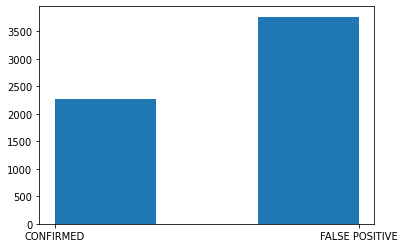

In [11]:
#Display distribution of Objective variable
plt.hist(DF.koi_disposition,bins=3)
plt.show() 

    
    Given the distribution of our variable of interest we can observe that 38% are CONFIRMED and 62% are FALSE POSITIVE. 

    Creating two sampled dataframes for each category in koi_disposition variable. I have selected a sample of 2,000 rows per dataframe which totals 4,000 rows of our New Dataframe. 

In [12]:
#Assign randome state for reproducibility of project
Random_State = 31

#creating sampled df for 'False Positive' dispositions
False_positive_sample = DF[DF.koi_disposition=='FALSE POSITIVE']
False_positive_sample = False_positive_sample.sample(n=2000,random_state=Random_State)
False_positive_sample.reset_index(drop=True,inplace=True)
print('False Positive Shape: ',False_positive_sample.shape)  


#creating sampled df for 'CONFIRMED' dispositions
Confirmed_sample = DF[DF.koi_disposition=='CONFIRMED']
Confirmed_sample = Confirmed_sample.sample(n=2000,random_state=Random_State)
Confirmed_sample.reset_index(drop=True,inplace=True)
print('Confirmed Shape: ',Confirmed_sample.shape)  


False Positive Shape:  (2000, 30)
Confirmed Shape:  (2000, 30)


Creating subsampled dataset

In [13]:
#Concatenate sampled dataframe to create our sub-sampled dataframe 
DF=pd.concat([False_positive_sample,Confirmed_sample],axis=0)

#shuffle the order of the dataframe 
DF = DF.sample(frac=1).reset_index(drop=True)

#New DF shape
print('Our new subsampled DF has Shape:',DF.shape)

Our new subsampled DF has Shape: (4000, 30)


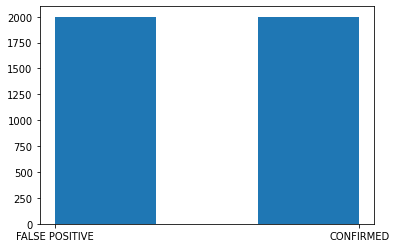

In [15]:
#Display distribution of Objective variable
plt.hist(DF.koi_disposition,bins=3)
plt.show() 

# UMAP #

    Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation, but also for general non-linear dimension reduction. Now that we have created a new DF which has uniformaly Distributed Data we can apply it to UMAP. UMAP is a Unsupervised Machine Learning technique which creates Clusters of our data, it can be vary useful for Scientist since allows to visualize the clusters. UMAP is Clustering all of our data. In UMAP clusters closer to each other mean that the data is 'related' to each other.

    Our variable of interest is Categorical. Yet, UMAP only accepts numerical dtypes. Thus, we need to convert our category into 1, which represents Confirmed exoplanets and 0, as a false positive. 

In [16]:
#Convert to numeric 
DF['koi_disposition'].replace(['CONFIRMED','FALSE POSITIVE'],[1,0],inplace=True)

In [17]:
reducer = umap.UMAP(random_state=31)

    UMAP is going to reduce the dimensionality of our matrix. converting from (4000 x 30) to (4000 x 2)

In [18]:
test = DF.values
scaled_test_data = StandardScaler().fit_transform(test) 
embedding = reducer.fit_transform(scaled_test_data)
embedding.shape

(4000, 2)

**Figure 1: koi_disposition UMAP Cluter**

    Figure 1 is probably the most important UMAP since it colors the clusters by the variable of interest. Below, we can see various clusters groups although, noticebly Confirmed and False positive values are easily clustered at different areas within UMAP. This means that the UMAP algorithim is doing a great job at distinguishing between koi_dispositions and the model can recognize with accuracy. 

Text(0.5, 1.0, 'UMAP koi_disposition')

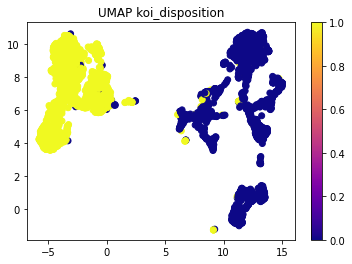

In [19]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],c=DF.koi_disposition,cmap='plasma')

plt.gca()
plt.colorbar()
plt.title('UMAP koi_disposition')

**Figure 2:  koi_fpflag_ss UMAP Cluter**

Text(0.5, 1.0, 'UMAP koi_fpflag_ss')

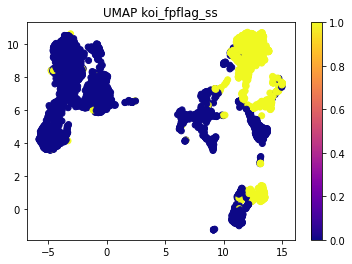

In [20]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],c=DF.koi_fpflag_ss,cmap='plasma')

plt.gca()
plt.colorbar()
plt.title('UMAP koi_fpflag_ss')

**Figure 3: koi_fpflag_co UMAP Cluter**

Text(0.5, 1.0, 'UMAP koi_fpflag_co')

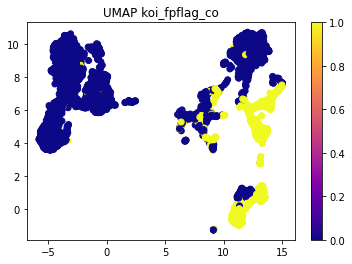

In [21]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],c=DF.koi_fpflag_co,cmap='plasma')

plt.gca()
plt.colorbar()
plt.title('UMAP koi_fpflag_co')

**Figure 4 :  koi_fpflag_ec UMAP Cluter**

Text(0.5, 1.0, 'UMAP koi_fpflag_ec')

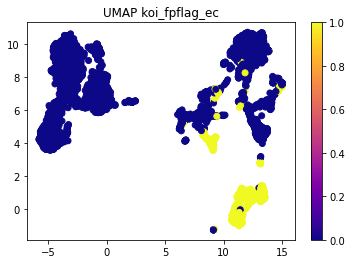

In [22]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],c=DF.koi_fpflag_ec,cmap='plasma')

plt.gca()
plt.colorbar()
plt.title('UMAP koi_fpflag_ec')

**Figure 5: koi_depth UMAP Cluster**

Text(0.5, 1.0, 'UMAP koi_depth')

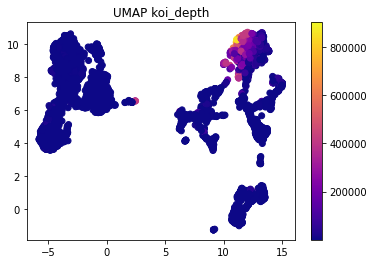

In [23]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],c=DF.koi_depth,cmap='plasma')

plt.gca()
plt.colorbar()
plt.title('UMAP koi_depth')

## Deep Learning Modeling ##

In [24]:
#Define our variables of input(X) and the variable we intend to predict(Y)
X = DF.iloc[:,1:30]
Y = DF.iloc[:,0]

**Utilize Scaler**

    Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus, to deal with this potential problem feature-wise normalization such as MinMax & Standard Scaling are usually used. 

In [25]:
#Normalizing features with MinMax Scaler
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

In [26]:
#Create train_test_split of our dataset
(X_train, X_test, y_train, y_test) = train_test_split( X_scale, Y, test_size=0.25)

In [27]:
#Normalizing features with Standard Scaler
scaler = StandardScaler()

x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

    Print out the shape of our training and test datasets.

In [28]:
print('X shape:{0}, y shape:{1}'.format(X.shape, Y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(4000, 29), y shape:(4000,)
X_train shape:(3000, 29), y_train shape:(3000,)
X_test shape:(1000, 29), y_test shape:(1000,)


# Create Models using Neural Networks

##  Model 0  - withought Regulariation

    This first model was was randomly created to observe the behavior of the accuracy. This model is not the most efficient since it does not have any regulation in order to prevent overfitting the model. I will display it only to compare with further models and compare accuracy. 

In [29]:
inputs = keras.Input(shape=(29, ), name='input_layer')


## First hidden layer
l_1 = layers.Dense(300, activation='relu')(inputs)
l_2 = layers.Dense(256, activation='relu')(l_1)
l_3 = layers.Dense(120, activation='relu')(l_2)

## output layer
outputs = layers.Dense(1, activation='softmax')(l_3)
                       

model = keras.Model(inputs=inputs, outputs=outputs)


2022-09-11 12:40:23.945075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['accuracy']
)

In [31]:
history= model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=60)

Epoch 1/100
40/40 [==============================] - 1s 7ms/step - loss: 0.4888 - accuracy: 0.5113 - val_loss: 0.5117 - val_accuracy: 0.4883
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4888 - accuracy: 0.5113 - val_loss: 0.5117 - val_accuracy: 0.4883
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4888 - accuracy: 0.5113 - val_loss: 0.5117 - val_accuracy: 0.4883
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4888 - accuracy: 0.5113 - val_loss: 0.5117 - val_accuracy: 0.4883
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4888 - accuracy: 0.5113 - val_loss: 0.5117 - val_accuracy: 0.4883
Epoch 6/100
40/40 [==============================] - 0s 5ms/step - loss: 0.4888 - accuracy: 0.5113 - val_loss: 0.5117 - val_accuracy: 0.4883
Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 0.4888 - accuracy: 0.5113 - val_loss: 0.5117 - val_accuracy: 0.4883
Epoch 8/100
4

In [32]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.5199999809265137
Test Accuracy: 0.47999998927116394


# Model 1

In [33]:
inputs = keras.Input(shape=(29, ), name='input_layer')


## First hidden layer
l_1 = layers.Dense(126, activation='relu',name='l_1')(inputs)
l_1 = layers.BatchNormalization()(l_1)
l_1 = layers.Dropout(0.2)(l_1)


## output layer
outputs = layers.Dense(1, activation='softmax',name='output_layer')(l_1)
                       

model = keras.Model(inputs=inputs, outputs=outputs)


In [34]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [35]:
history= model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=16)

Epoch 1/100
150/150 [==============================] - 1s 4ms/step - loss: 0.1335 - accuracy: 0.5113 - val_loss: 0.3660 - val_accuracy: 0.4883
Epoch 2/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0621 - accuracy: 0.5113 - val_loss: 0.1333 - val_accuracy: 0.4883
Epoch 3/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0539 - accuracy: 0.5113 - val_loss: 0.0533 - val_accuracy: 0.4883
Epoch 4/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0556 - accuracy: 0.5113 - val_loss: 0.0446 - val_accuracy: 0.4883
Epoch 5/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0535 - accuracy: 0.5113 - val_loss: 0.0427 - val_accuracy: 0.4883
Epoch 6/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0566 - accuracy: 0.5113 - val_loss: 0.0502 - val_accuracy: 0.4883
Epoch 7/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0461 - accuracy: 0.5113 - val_loss: 0.0526 - val_accuracy: 0.4883

In [36]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.05651295557618141
Test Accuracy: 0.47999998927116394


# Model 2 - Winner !!!



**Model description:**

    Hidden Layers: 2

    Neurons per Layer: 126

    Activation of Hidden Layers: RELU

    Output activation: Sigmoid


**Regulation Techniques used:** 

    Made Model more simple : Reduced the amount of Layers and neurons

    Iplemented BatchNormalization for both Hidden Layers (L1 & L2)

    Implemented Dropout for L1 

    Reduced batch size of model.fit to 16

In [37]:
inputs = keras.Input(shape=(29, ), name='input_layer')


## First hidden layer
l_1 = layers.Dense(126, activation='relu',name='l_1')(inputs)
l_1 = layers.BatchNormalization()(l_1)
l_1 = layers.Dropout(0.2)(l_1)

## Second hidden layer
l_2 = layers.Dense(126, activation='relu',name='l_2')(l_1)
l_2 = layers.BatchNormalization()(l_2)


## output layer
outputs = layers.Dense(1, activation='sigmoid',name='output_layer')(l_2)
                       

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 29)]              0         
                                                                 
 l_1 (Dense)                 (None, 126)               3780      
                                                                 
 batch_normalization_1 (Batc  (None, 126)              504       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 126)               0         
                                                                 
 l_2 (Dense)                 (None, 126)               16002     
                                                                 
 batch_normalization_2 (Batc  (None, 126)              504       
 hNormalization)                                           

In [38]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['accuracy'])

In [39]:
history= model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=16)

Epoch 1/100
150/150 [==============================] - 2s 5ms/step - loss: 0.0416 - accuracy: 0.9729 - val_loss: 0.2265 - val_accuracy: 0.9867
Epoch 2/100
150/150 [==============================] - 1s 3ms/step - loss: 0.0151 - accuracy: 0.9871 - val_loss: 0.0416 - val_accuracy: 0.9867
Epoch 3/100
150/150 [==============================] - 1s 3ms/step - loss: 0.0152 - accuracy: 0.9875 - val_loss: 0.0146 - val_accuracy: 0.9867
Epoch 4/100
150/150 [==============================] - 1s 4ms/step - loss: 0.0137 - accuracy: 0.9875 - val_loss: 0.0134 - val_accuracy: 0.9867
Epoch 5/100
150/150 [==============================] - 1s 3ms/step - loss: 0.0135 - accuracy: 0.9871 - val_loss: 0.0133 - val_accuracy: 0.9867
Epoch 6/100
150/150 [==============================] - 1s 3ms/step - loss: 0.0139 - accuracy: 0.9875 - val_loss: 0.0133 - val_accuracy: 0.9867
Epoch 7/100
150/150 [==============================] - 1s 3ms/step - loss: 0.0125 - accuracy: 0.9879 - val_loss: 0.0133 - val_accuracy: 0.9867

In [40]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.012000000104308128
Test Accuracy: 0.9879999756813049


    Model 2 Returns a Test Accuracy of 0.99% Accuracy this means that the parameters used on the neural network are appropriate to identify the diffierence between (1 == Confirmed) and (0 == False Positive). Test Loss is low which could be a good indicator of higher validation accuracy. 

# Model Reproducibility:

    The following code is used to predict the desired KOI_disposition. (1 == Confirmed, 0 == False positive).
    The data must follow the same data trnsformation procedures as our training dataset. 

In [41]:
# Modify the function input for desired prediction


def prediction(x):
    yhat = model.predict(x)
    #return(yhat)

prediction(X_test)



32/32 [==============================] - 0s 1ms/step
